# Data Science Capstone  
## Analyzing Gaming Addiction Trends and Player Engagement


In [46]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import scipy.stats as stats
import time
import itertools

import warnings
warnings.filterwarnings('ignore')

The `games_data` and `users_data` datasets were extracted from the **Steam Web API**, specifically using the **ISteamApps/GetAppList** and **IPlayerService/GetOwnedGames** endpoints.  

- **`steam_game_data.csv`** : This dataset contains detailed information about 85,430 games, including metadata such as the game title, developer, publisher, genre, release date, supported platforms, multiplayer support, graphics quality, story depth, and metrics like review scores and player engagement statistics.  

- **`user_playtime_data.csv`** : This dataset consists of 66,187 player-specific data, capturing metrics like total playtime, recent playtime, and game ownership information. Each user (`user_id`) can have multiple games (`game_id`) associated with their account.  

Let's load these datasets:  

##  `games_data`

In [9]:
games_data = pd.read_csv("games_data2.csv")
users_data = pd.read_csv("user_playtime_data2.csv")

In [10]:
# Let's look at the first 5 elements of the games_data
games_data.head()

,game_id,title,developer,publisher,genre,release_date,platforms,multiplayer_support,graphics_quality,story_depth,DLC_count,max_concurrent_players,positive_review_pct,average_review_score,review_sentiment_score,number_of_reviews
0,916690,Need to Know - Official Soundtrack,Monomyth Games,Monomyth Games,"Adventure, Indie, Simulation","Oct 22, 2018","windows, mac, linux",False,Standard,Light,0,0,0,0,0,0
1,916720,Fantasy Grounds - Pathfinder RPG - Return of t...,"SmiteWorks USA, LLC",Unknown,"Indie, RPG, Strategy","Sep 19, 2018","windows, mac",True,Standard,Light,0,0,0,0,0,0
2,916730,Gato Roboto,doinksoft,Devolver Digital,"Action, Adventure, Indie","May 30, 2019",windows,False,Standard,Light,1,8,79,79,79,3707
3,916771,Dreadnought Renegade Stash DLC,"Six Foot, YAGER",Grey Box,"Action, Free To Play, Massively Multiplayer","Oct 14, 2018",windows,True,Standard,Light,0,0,0,0,0,0
4,916772,Dreadnought Rogue Cache DLC,"Six Foot, YAGER",Grey Box,"Action, Free To Play, Massively Multiplayer","Oct 14, 2018",windows,True,Standard,Light,0,0,0,0,0,0


In [11]:
games_data.count()

game_id                   85430
title                     85410
developer                 85422
publisher                 85362
genre                     75435
release_date              84629
platforms                 85430
multiplayer_support       85430
graphics_quality          85430
story_depth               85430
DLC_count                 85430
max_concurrent_players    85430
positive_review_pct       85430
average_review_score      85430
review_sentiment_score    85430
number_of_reviews         85430
dtype: int64

We can observe that most columns in the `games_data` dataset have 23,132 entries, with a few exceptions like `title`, `developer`, `publisher`, `genre`, and `release_date`, suggesting potential missing values.


In [12]:
games_data.shape

(85430, 16)

In [13]:
games_data.dtypes

game_id                    int64
title                     object
developer                 object
publisher                 object
genre                     object
release_date              object
platforms                 object
multiplayer_support         bool
graphics_quality          object
story_depth               object
DLC_count                  int64
max_concurrent_players     int64
positive_review_pct        int64
average_review_score       int64
review_sentiment_score     int64
number_of_reviews          int64
dtype: object

Most of the data in the `games_data` dataset are of the `object` type, with numerical metrics stored as `int64` and `multiplayer_support` as a boolean (`bool`).


In [14]:
#let's look for the missing values

games_missing_values = games_data.isnull().sum()
games_missing_values

game_id                      0
title                       20
developer                    8
publisher                   68
genre                     9995
release_date               801
platforms                    0
multiplayer_support          0
graphics_quality             0
story_depth                  0
DLC_count                    0
max_concurrent_players       0
positive_review_pct          0
average_review_score         0
review_sentiment_score       0
number_of_reviews            0
dtype: int64

### Let's remove those missing values:

In [15]:
# Removing rows with any missing values
games_data.dropna(inplace=True)

In [16]:
games_data.shape

(75100, 16)

After removing missing values, the `games_data` dataset is reduced to **18,479 rows** across **16 columns**,

In [17]:
games_data.count()

game_id                   75100
title                     75100
developer                 75100
publisher                 75100
genre                     75100
release_date              75100
platforms                 75100
multiplayer_support       75100
graphics_quality          75100
story_depth               75100
DLC_count                 75100
max_concurrent_players    75100
positive_review_pct       75100
average_review_score      75100
review_sentiment_score    75100
number_of_reviews         75100
dtype: int64

In [18]:

# Attemptting to parse the dates with possible date formats : 
# Possible formats known from: https://steamcommunity.com/sharedfiles/filedetails/?id=2554483179#:~:text=Date%20part%20order%20can%20be,format%20will%20be%20applied%20immediately.

valid_dates_format1 = pd.to_datetime(games_data['release_date'], format='%d %b, %Y', errors='coerce')
valid_dates_format2 = pd.to_datetime(games_data['release_date'], format='%b %d, %Y', errors='coerce')
valid_dates_format3 = pd.to_datetime(games_data['release_date'], format='%d %b %Y', errors='coerce')

# Identify rows that do not match either of the formats
invalid_dates = games_data[(valid_dates_format1.isna()) & (valid_dates_format2.isna()) & (valid_dates_format3.isna())]

# Display rows with invalid date formats
print("Rows with invalid date formats:")
print(invalid_dates[['release_date']])

print("There are a total of ", len(invalid_dates), "invalid dates")


Rows with invalid date formats:
      release_date
6      Coming soon
83     Coming soon
129    Coming soon
150    Coming soon
163    Coming soon
...            ...
85394  Coming soon
85400  Coming soon
85412  Coming soon
85414  Coming soon
85427  Coming soon

[8913 rows x 1 columns]
There are a total of  8913 invalid dates


We can observe that for some games that have not been released yet, the `release_date` column contains values like **Q2 2025**, **To be announced**, and **Coming soon**, along with some dates in different language formats, so let's remove them since we won't be needing those for our analysis.


In [19]:
# let's remove those invalid dates
invalid_dates_list = invalid_dates['release_date'].tolist()
games_data = games_data[~games_data['release_date'].isin(invalid_dates_list)]

In [20]:
games_data.count()

game_id                   66187
title                     66187
developer                 66187
publisher                 66187
genre                     66187
release_date              66187
platforms                 66187
multiplayer_support       66187
graphics_quality          66187
story_depth               66187
DLC_count                 66187
max_concurrent_players    66187
positive_review_pct       66187
average_review_score      66187
review_sentiment_score    66187
number_of_reviews         66187
dtype: int64

After removing those invalid dates, the `games_data` dataset now contains **12,814** entries across all columns. We now have only relevant release dates are included for analysis.

Now, let's make the date format consistent in all rows


In [21]:
# Combining all parsed dates
games_data['release_date'] = valid_dates_format1.fillna(valid_dates_format2).fillna(valid_dates_format3)

# Convert dates to 'YYYY-MM-DD' format for consistency only
games_data['release_date'] = games_data['release_date'].dt.strftime('%Y-%m-%d')

# `users_data`

In [22]:
# Let's look at the first 5 elements of the users_data
users_data.head()

,user_id,game_count,appid,name,playtime_forever,playtime_2weeks
0,76561198450606184,24,500,Left 4 Dead,0,0
1,76561198450606184,24,550,Left 4 Dead 2,0,0
2,76561198450606184,24,41070,Serious Sam 3: BFE,56,0
3,76561198450606184,24,564310,Serious Sam Fusion 2017 (beta),0,0
4,76561198450606184,24,203160,Tomb Raider,0,0


In [23]:
users_data.count()

user_id             211510
game_count          211510
appid               211510
name                211510
playtime_forever    211510
playtime_2weeks     211510
dtype: int64

The `users_data` dataset contains **65,494** entries across all columns.

In [24]:
users_data.shape

(211510, 6)

In [25]:
users_data.dtypes

user_id              int64
game_count           int64
appid                int64
name                object
playtime_forever     int64
playtime_2weeks      int64
dtype: object

Most of the data in the `users_data` dataset are of the `int64` type, with only the `name` column being of the `object` type. We have numerical data for user gaming behavior analysis.


In [26]:
# let's look for missing values
users_missing_values = users_data.isnull().sum()
users_missing_values

user_id             0
game_count          0
appid               0
name                0
playtime_forever    0
playtime_2weeks     0
dtype: int64

No mising values

In [27]:
# Rename the column from 'appid' to 'game_id'
users_data.rename(columns={'appid': 'game_id'}, inplace=True)

Since one user can have multiple data entries, the `user_id` column can be repeated for the same person, so let's check the number of unique users and unique games in the `users_data` dataset.


In [28]:
print("There are ", len(users_data['user_id'].unique()) , " unique users in our user dataset")

There are  3593  unique users in our user dataset


In [29]:
print("There are ", len(users_data['game_id'].unique()) , " unique games in our user dataset")

There are  17085  unique games in our user dataset


In [30]:
# if they played RECENTLY, playtime_2weeks will be greater than 0

# Filter players with recent playtime (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played recently: {unique_recent_players_count}")


Number of unique users who played recently: 1136


In [31]:
# If they are genuine players, `playtime_forever` will be greater than 0.
# I am considering the fact that some users might just create an account and never actually play.


# Filter players with at least some playtime (playtime_forever > 0)
recent_players = users_data[users_data['playtime_forever'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played at least a min: {unique_recent_players_count}")


Number of unique users who played at least a min: 3177


In [32]:
# let's add avg_playtime coloumn - for viz
users_data['avg_playtime'] = users_data['playtime_2weeks'] / 14

Let's do some visualizations

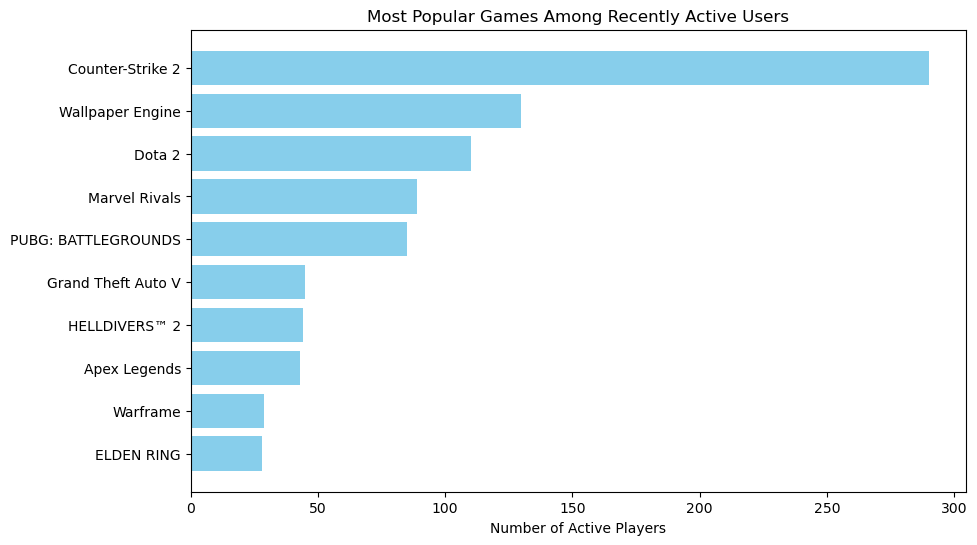

In [33]:

# Most Popular Games Among Recently Active Users (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]
most_popular_games = recent_players['name'].value_counts().head(10).reset_index()
most_popular_games.columns = ['Game', 'Active Players']

# Visualization: Most Popular Games
plt.figure(figsize=(10, 6))
plt.barh(most_popular_games['Game'], most_popular_games['Active Players'], color='skyblue')
plt.xlabel('Number of Active Players')
plt.title('Most Popular Games Among Recently Active Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **Counter-Strike 2** leading by a significant margin, followed by **Wallpaper Engine** and **Dota 2**.

Interestingly, while **Counter-Strike 2**, **Dota 2**, and **PUBG: BATTLEGROUNDS** are well-known for maintaining high player counts globally, titles like **Marvel Rivals** and **Wallpaper Engine** attract players with their casual and practical uses.


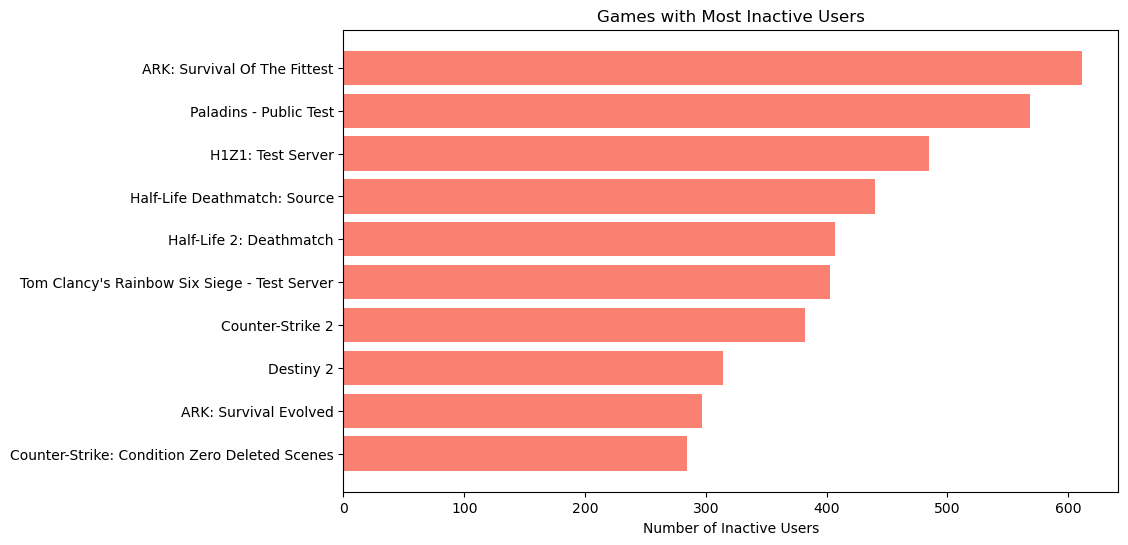

In [34]:
# Inactive Users with Zero Playtime and Their Associated Games
inactive_users = users_data[(users_data['playtime_forever'] == 0) & (users_data['playtime_2weeks'] == 0)]
inactive_user_games = inactive_users['name'].value_counts().head(10).reset_index()
inactive_user_games.columns = ['Game', 'Inactive User Count']

plt.figure(figsize=(10, 6))
plt.barh(inactive_user_games['Game'], inactive_user_games['Inactive User Count'], color='salmon')
plt.xlabel('Number of Inactive Users')
plt.title('Games with Most Inactive Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **ARK: Survival Of The Fittest**, **Paladins - Public Test**, and **H1Z1: Test Server** leading the list.  

Interestingly, many of the top inactive games are **test servers** or **public test versions**, suggesting that players might try these versions briefly without continuing to play regularly.  

Let's also note here that even popular titles like **Counter-Strike 2** and **Destiny 2** appear on this list. This indicates that not all players remain engaged over time.


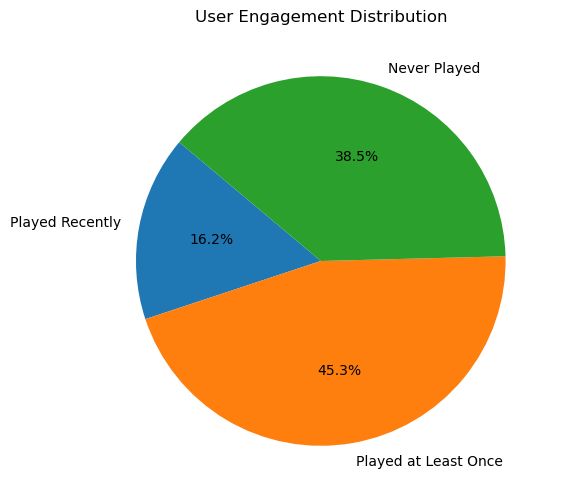

In [35]:
# lets see how many played recently, played at least once and never played at all
engagement_labels = ['Played Recently', 'Played at Least Once', 'Never Played']
engagement_counts = [
    recent_players['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] > 0]['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] == 0]['user_id'].nunique()
]

plt.figure(figsize=(6, 6))
plt.pie(engagement_counts, labels=engagement_labels, autopct='%1.1f%%', startangle=140)
plt.title('User Engagement Distribution')
plt.show()

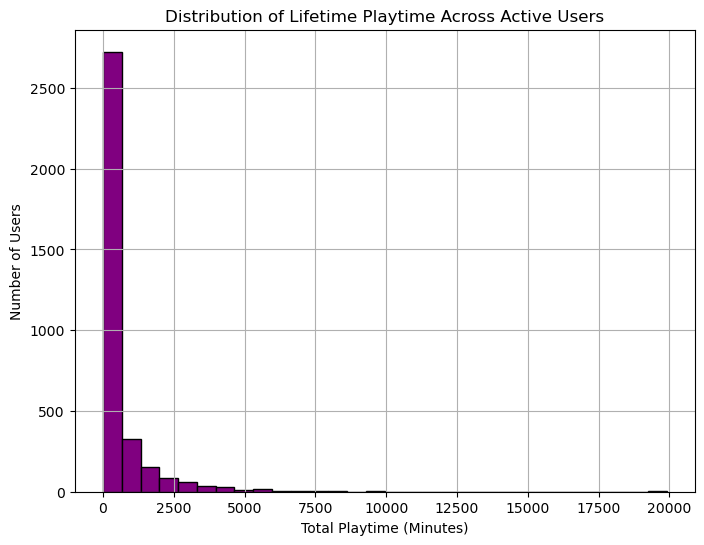

In [36]:
# let's observe the distribution of lifetime Playtime Across Active Users

# Filter only users with playtime_forever > 0
active_users = users_data[users_data['playtime_2weeks'] > 0]

# Create a histogram for active users
plt.figure(figsize=(8, 6))
plt.hist(active_users['playtime_2weeks'], bins=30, color='purple', edgecolor='black')
plt.xlabel('Total Playtime (Minutes)')
plt.ylabel('Number of Users')
plt.title('Distribution of Lifetime Playtime Across Active Users')
plt.grid(True)
plt.show()


According to the histogram, the majority of users have a **low total playtime**, mainly under **2000 minutes**.  

The **right-skewed distribution** indicates that while most players spend limited time in games, a small number of users have **extremely high playtimes**, potentially pointing to **high engagement** or **gaming addiction**.

We will later explore these **outliers** to understand what drives such high playtime and if specific games contribute to this behavior.


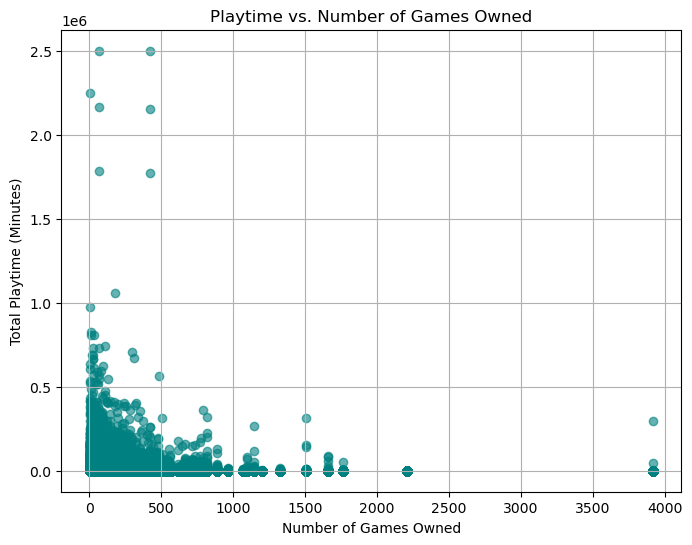

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(users_data['game_count'], users_data['playtime_forever'], alpha=0.6, color='teal')
plt.xlabel('Number of Games Owned')
plt.ylabel('Total Playtime (Minutes)')
plt.title('Playtime vs. Number of Games Owned')
plt.grid(True)
plt.show()


The scatter plot shows most users clustering around **low playtime** and **fewer owned games**.  

While a few users own **hundreds to over a thousand games**, their total playtime does not always scale up, suggesting that **game collectors**(those who own lots of games) may not necessarily be **active players**.  

Again, we can see few **outliers** with **extremely high playtime**, indicating possible **addictive behavior**, regardless of the total number of games owned.


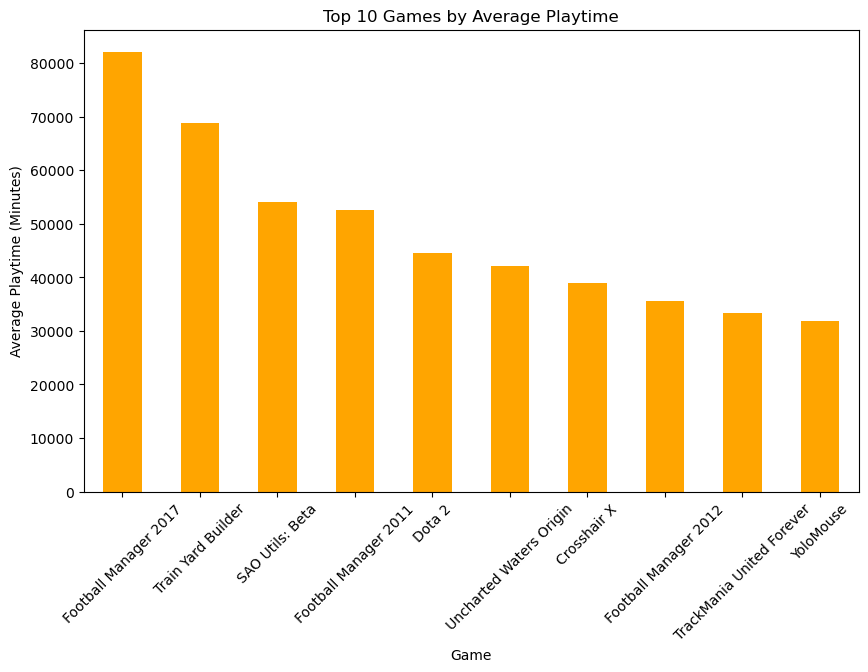

In [38]:
average_playtime_per_game = users_data.groupby('name')['playtime_forever'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
average_playtime_per_game.plot(kind='bar', color='orange')
plt.xlabel('Game')
plt.ylabel('Average Playtime (Minutes)')
plt.title('Top 10 Games by Average Playtime')
plt.xticks(rotation=45)
plt.show()


The bar chart shows **YoloMouse** leading by a significant margin, followed by **Idling to Rule the Gods** and **GameMaker: Studio**.  

Most of these top games with high average playtime are **idle games**, which often encourage **longer running sessions** without active engagement.  

But we can see **Dota 2**, which interestingly is the only **competitive multiplayer game** in this list, showing that while **idle games** dominate average playtime, some traditional games also maintain **high engagement** among their player base.


In [39]:
#Dherai game khelne haru 30 hours
high_playtime_count = (users_data['playtime_2weeks'] / 2 > 1800).sum()
high_playtime_count

102

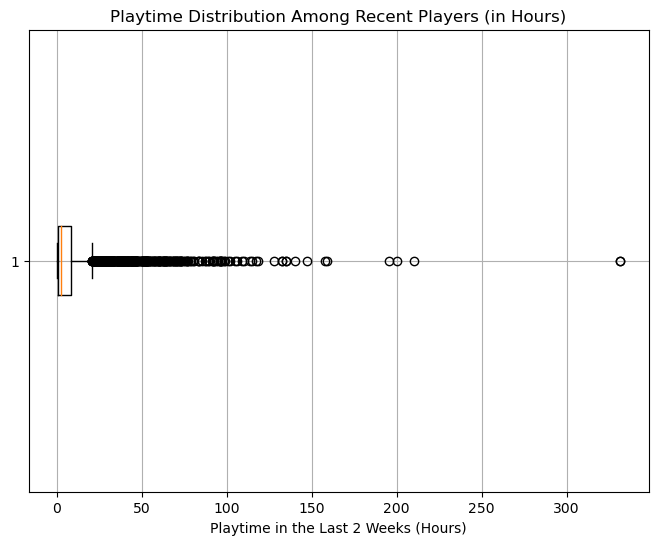

In [42]:
# let's see a box plot
recent_players['playtime_hours'] = recent_players['playtime_2weeks'] / 60

plt.figure(figsize=(8, 6))
plt.boxplot(recent_players['playtime_hours'], vert=False)
plt.xlabel('Playtime in the Last 2 Weeks (Hours)')
plt.title('Playtime Distribution Among Recent Players (in Hours)')
plt.grid(True)
plt.show()

## Q1. How much time are people spending on gaming per week, and what does it reveal about gaming addiction trends?

In [43]:
# let's first filter only active users
active_users = users_data[users_data['playtime_2weeks'] > 0]

# calculate weekly playtime (in hours) for those active uses
active_users['weekly_playtime_hours'] = (active_users['playtime_2weeks'] / 2) / 60

# Descriptive statistics of weekly playtime 
active_playtime_stats = active_users['weekly_playtime_hours'].describe()
print("Weekly Playtime Statistics for Active Users (in Hours):")
print(active_playtime_stats)


Weekly Playtime Statistics for Active Users (in Hours):
count    3460.000000
mean        4.673247
std         9.859763
min         0.008333
25%         0.258333
50%         1.200000
75%         4.312500
max       165.841667
Name: weekly_playtime_hours, dtype: float64


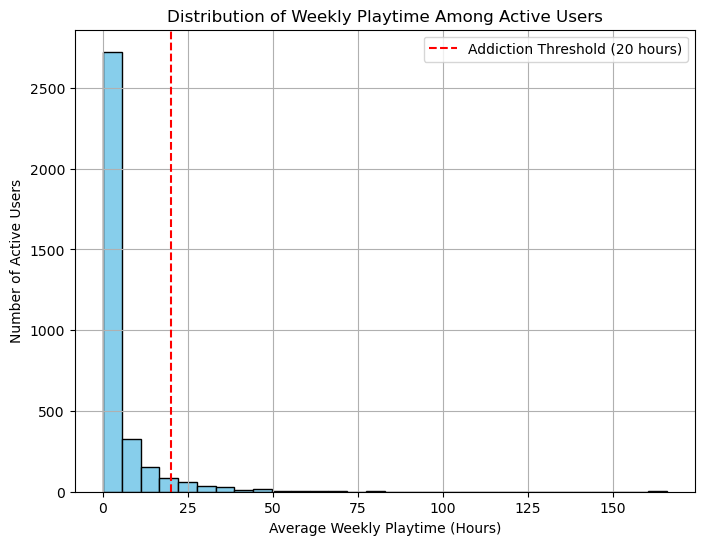

In [41]:
# visualization the  distribution of weekly playtime
plt.figure(figsize=(8, 6))
plt.hist(active_users['weekly_playtime_hours'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=20, color='red', linestyle='--', label='Addiction Threshold (20 hours)')
plt.xlabel('Average Weekly Playtime (Hours)')
plt.ylabel('Number of Active Users')
plt.title('Distribution of Weekly Playtime Among Active Users')
plt.legend()
plt.grid(True)
plt.show()


Active User Distribution by Playtime Category:
playtime_category
Casual Gamer           2836
Moderate Gamer          420
Potential Addiction     204
Name: count, dtype: int64


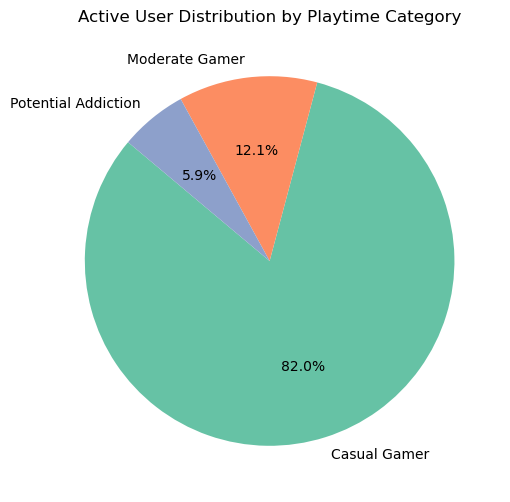

In [36]:

# Lets also cateogrize active users based on weekly playtime
def categorize_playtime(hours):
    if hours < 7:
        return 'Casual Gamer'
    elif hours < 20:
        return 'Moderate Gamer'
    else:
        return 'Potential Addiction'

active_users['playtime_category'] = active_users['weekly_playtime_hours'].apply(categorize_playtime)

# total active users in each category
active_category_counts = active_users['playtime_category'].value_counts()
print("\nActive User Distribution by Playtime Category:")
print(active_category_counts)

plt.figure(figsize=(6, 6))
plt.pie(active_category_counts, labels=active_category_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Active User Distribution by Playtime Category')
plt.show()



- **Majority of Active Users:** 83.6% are **Casual Gamers**, playing **less than 7 hours per week**.  
- **Moderate Gamers:** 10.9% play **between 7 to 20 hours per week**, showing **healthy engagement**.  
- **Potential Addiction:** 5.5% of active users exceed **20 hours per week**, indicating a **possible risk of gaming addiction**.  


With only **5.5%** of active users in the '**Potential Addiction**' category, **gaming addiction** does not seem to be a **significant trend** in the dataset.  

The overwhelming majority of active users are **casual gamers**. This suggests that **most people use gaming as a light, recreational activity**. And also may indicate that **games are engaging enough for short sessions but not overly addictive**.  


The **10.9%** of **moderate gamers** play **7 to 20 hours per week**, showing a **healthy interest** in gaming.


The **histogram** shows a **long tail**, with a **few users playing well beyond 40 hours per week**.


## Q2. Which game design elements—such as microtransactions, progression systems, and multiplayer vs. single-player structures—are most associated with prolonged playtime and potential addiction? 

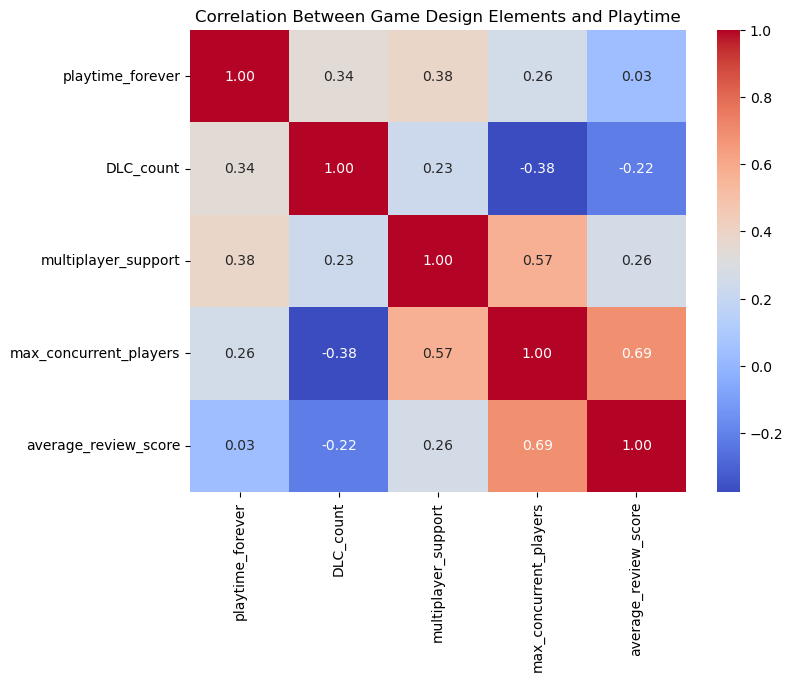

In [114]:

# Merging user_data with games_data on game_id
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

merged_data = merged_data[merged_data["playtime_2weeks"] > 1800] # 30 hours

# game design elements for analysis
design_elements = ["DLC_count", "multiplayer_support", "max_concurrent_players", 
                    "average_review_score"]

# correlation of game design elements with playtime_forever
correlation_results = merged_data[["playtime_forever"] + design_elements].corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Game Design Elements and Playtime")
plt.show()



The heatmap shows that **multiplayer support (0.38) and DLC count (0.34)** have the strongest positive correlations with playtime, suggesting that games with **multiplayer features and additional content tend to retain players longer**. 

While **max concurrent players (0.26) and average review score (0.03)** have weaker correlations, the **negative correlation between DLC count and max concurrent players (-0.38)** implies that highly DLC-driven games may not always have the highest player engagement at once.


T-test Statistic: 2.25, P-value: 0.03214


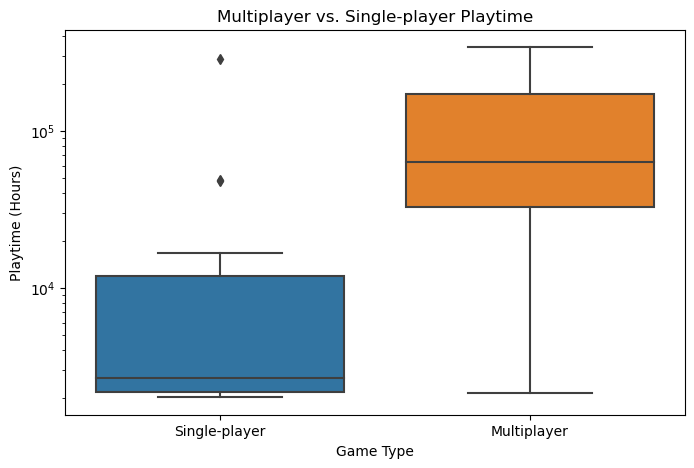

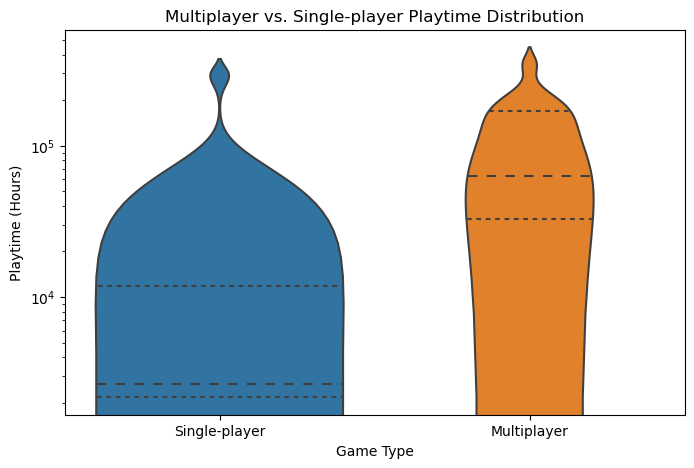

In [115]:

#  Multiplayer vs. Single-player Playtime
# T-test
multiplayer_playtime = merged_data[merged_data["multiplayer_support"] == 1]["playtime_forever"]
singleplayer_playtime = merged_data[merged_data["multiplayer_support"] == 0]["playtime_forever"]

t_stat, p_value = stats.ttest_ind(multiplayer_playtime, singleplayer_playtime, equal_var=False)
print(f"T-test Statistic: {t_stat:.2f}, P-value: {p_value:.5f}")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_data["multiplayer_support"], y=merged_data["playtime_forever"])
plt.xticks([0, 1], ["Single-player", "Multiplayer"])
plt.xlabel("Game Type")
plt.ylabel("Playtime (Hours)")
plt.title("Multiplayer vs. Single-player Playtime")
plt.yscale("log")  # Adjust scale due to high variance
plt.show()

# violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(x=merged_data["multiplayer_support"], y=merged_data["playtime_forever"], inner="quartile")
plt.xticks([0, 1], ["Single-player", "Multiplayer"])
plt.xlabel("Game Type")
plt.ylabel("Playtime (Hours)")
plt.title("Multiplayer vs. Single-player Playtime Distribution")
plt.yscale("log")  # Log scale for better visibility
plt.show()


The violin plot shows that **multiplayer games have significantly higher playtime distributions compared to single-player games**, with a greater concentration of players spending **tens of thousands of hours** in multiplayer experiences.

The **wider upper distribution in multiplayer games** suggests that they encourage prolonged engagement more than single-player titles, likely due to **social interactions, competitive elements, and continuous content updates**.


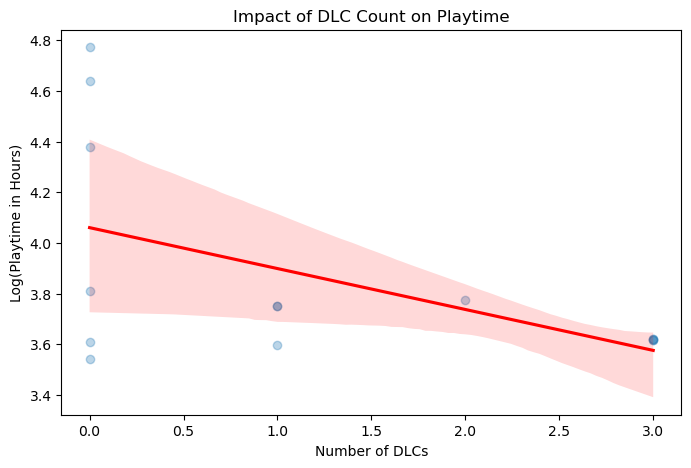

In [111]:

# remove extreme outliers ( games with >10,000 hours)
filtered_data = merged_data[merged_data["playtime_forever"] < 10000]

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=filtered_data["DLC_count"], 
            y=np.log1p(filtered_data["playtime_forever"]/60),  # Log transform playtime
            scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})

plt.xlabel("Number of DLCs")
plt.ylabel("Log(Playtime in Hours)")
plt.title("Impact of DLC Count on Playtime")
plt.show()


The regression plot suggests a **negative correlation** between DLC count and playtime, indicating that **games with more DLCs tend to have lower average playtime**. However, the small sample size and wide confidence interval suggest this trend may not be statistically significant.

This result contrasts with expectations, implying that additional content does not always drive long-term engagement. Other factors, such as **game quality, core mechanics, or monetization strategies**, may influence playtime more than DLC quantity.

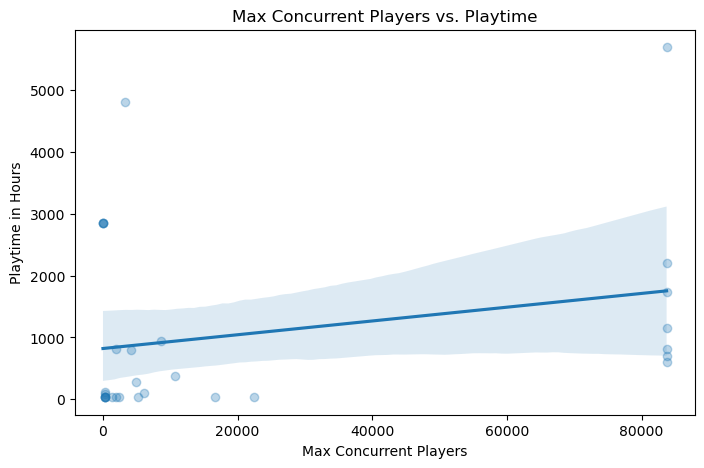

In [120]:

plt.figure(figsize=(8, 5))
sns.regplot(x=(merged_data["max_concurrent_players"]), 
            y=(merged_data["playtime_forever"]/60), scatter_kws={'alpha':0.3})
plt.xlabel("Max Concurrent Players")
plt.ylabel("Playtime in Hours")
plt.title("Max Concurrent Players vs. Playtime")
plt.show()


The regression plot suggests a **weak positive correlation** between max concurrent players and playtime, indicating that **games with more concurrent players tend to have slightly longer average playtime**. However, the **broad confidence interval** highlights significant variability.

While more popular games may encourage extended engagement, **other factors such as game design, progression systems, and monetization models** likely play a more critical role in determining overall playtime.


**Summary**

Games that encourage **social interaction, competition, and continuous progression** are the most likely to lead to prolonged playtime and potential addiction. Multiplayer games consistently show higher engagement, likely due to **ranked systems, cooperative play, and live-service updates** that keep players coming back. While **popular games with high concurrent players** tend to have longer playtime, this effect is weak, suggesting that **popularity alone doesn’t make a game addictive**—the mechanics do.

Surprisingly, **DLCs don’t strongly impact playtime**, and in some cases, more DLCs even correlate with slightly lower engagement. This suggests that additional content alone isn’t enough to keep players hooked unless paired with strong retention mechanics. Likewise, **review scores have little influence on playtime**, meaning **a game can be highly engaging (or addictive) even if it’s not highly rated**.

In short, **multiplayer elements, competitive progression systems, and ongoing content updates** are the biggest drivers of prolonged playtime and potential addiction, rather than DLCs or critical reception.


## Q3. Are certain game genres (e.g., MMORPGs, Battle Royales) more prone to fostering addiction, and what common design elements contribute to high engagement? 

## Q4. Do highly addictive games tend to have higher or lower ratings, and what are the most common sentiments expressed in player reviews? 